In [143]:
from __future__ import division
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, basename, exists
from os import makedirs
import matplotlib.pyplot as plt
from nilearn import input_data, datasets, plotting, regions
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from scipy.stats import pearsonr
import bct
import json
from matplotlib import pyplot as plt
%matplotlib inline

In [99]:
#choose your atlas and either fetch it from Nilearn using one of the the 'datasets' functions
laird_2011_icns = '/Users/Katie/Dropbox/Projects/physics-retrieval/18-networks-5.14.nii.gz'
#add labels for the parcellation
labels = ['limbic', 'orbitofrontal', 'basal ganglia', 'salience', 'hunger', 
          'motor learning', 'frontoparietal', 'hand', 'motor execution', 'higher order visual', 
          'lateral visual', 'medial visual', 'default mode',' cerebellum', 'left central executive', 
          'auditory', 'mouth', 'right central executive']

In [32]:
harvox_hippo = '/Users/Katie/Dropbox/Projects/physics-retrieval/harvox-hippo-prob50-2mm.nii.gz'

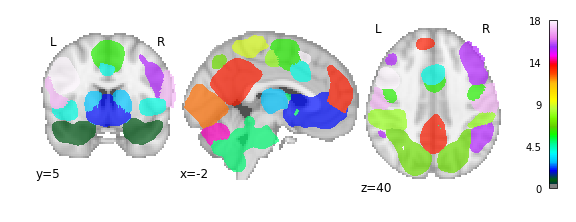

In [97]:
plotting.plot_roi(laird_2011_icns, cut_coords=(-2, 5, 40), colorbar=True, vmin=0, vmax=18, draw_cross=False)
plotting.show()
#dmn is 12
#lcen is 14
#rcen is 17

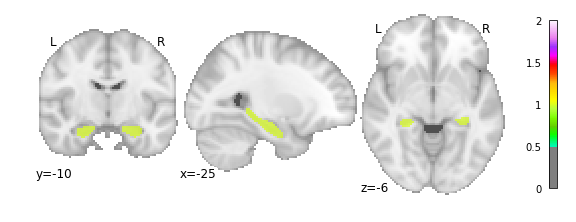

In [38]:
plotting.plot_roi(harvox_hippo, cut_coords=(-25, -10, -6), colorbar=True, vmin=0, vmax=2, draw_cross=False)
plotting.show()

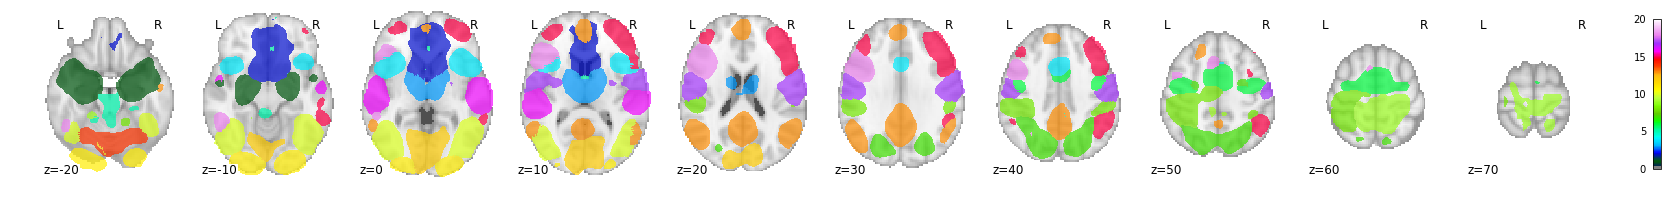

In [9]:
plotting.plot_roi(laird_2011_icns, cut_coords=(-20, -10, 0, 10, 20, 30, 40, 50, 60, 70), 
                  display_mode='z', colorbar=True, vmin=0, vmax=20, draw_cross=False)

In [100]:
#create your masker objects 
#(this is how to pull timeseries from niftis into arrays, based on your parcellations scheme)
#one masker to pull out one signal per network (average of voxelwise signals across the network)
network_masker = input_data.NiftiLabelsMasker(laird_2011_icns, standardize=True)
hippo_masker = input_data.NiftiLabelsMasker(harvox_hippo, standardize=True)
#one masker to pull out one signal per region (if applicable)
#region_masker = input_data.NiftiLabelsMasker('/Users/Katie/Dropbox/Data/salience-anxiety-graph-theory/relabeled_yeo_atlas7_gt100.nii.gz', standardize=True)

In [113]:
#only want post subjects
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
subjects = ['101', '102']

In [67]:
#data_dir = '/home/data/nbc/physics-learning/data/first-level'
data_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/'
#mni_data = '/home/data/nbc/
#mni_data = '/Users/Katie/Dropbox/Projects/physics-anxiety/data/post'
#sink_dir = '/home/data/nbc/anxiety-physics/output'
sink_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data/out'

runs = [0, 1]
connectivity_metric = 'correlation'
networks = [12, 14, 17]
conditions = ['phy', 'gen']
thresh_range = np.arange(0.1, 1, 0.1)

In [68]:
#gen_timing = np.genfromtxt('/home/data/nbc/physics-learning/physics-learning/RETRconditionGeneralSess1.txt', 
#                           delimiter='\t')
gen_timing = np.genfromtxt('/Users/Katie/Dropbox/Projects/physics-retrieval/data/RETRconditionGeneralSess1.txt', 
                           delimiter='\t', dtype=int)

gen_timing = (gen_timing/2)-1
gen_timing = gen_timing[:,0:2]

#phy_timing = np.genfromtxt('/home/data/nbc/physics-learning/physics-learning/RETRconditionPhysicsSess1.txt', 
#                           delimiter='\t')
phy_timing = np.genfromtxt('/Users/Katie/Dropbox/Projects/physics-retrieval/data/RETRconditionPhysicsSess1.txt', 
                           delimiter='\t')
phy_timing = (phy_timing/2)-1
phy_timing = phy_timing[:,0:2]
timing = {}
timing['phy'] = phy_timing
timing['gen'] = gen_timing

In [69]:
df = pd.DataFrame({'efficiency phys': np.empty([len(subjects),], dtype=float),
                   'fc default mode-left central executive phys': np.empty([len(subjects),], dtype=float),
                   'fc default mode-right central executive phys': np.empty([len(subjects),], dtype=float),
                   'fc left central executive-right central executive phys': np.empty([len(subjects),], dtype=float),
                   'fc hippo-default mode phys': np.empty([len(subjects),], dtype=float),
                   'fc hippo-left central executive phys': np.empty([len(subjects),], dtype=float),
                   'fc hippo-right central executive phys': np.empty([len(subjects),], dtype=float),
                   'le default mode phys': np.empty([len(subjects),], dtype=float),
                   'le right central executive phys': np.empty([len(subjects),], dtype=float),
                   'le left central executive phys': np.empty([len(subjects),], dtype=float),
                   'efficiency gen': np.empty([len(subjects),], dtype=float),
                   'fc default mode-left central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc default mode-right central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc left central executive-right central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc hippo-default mode gen': np.empty([len(subjects),], dtype=float),
                   'fc hippo-left central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc hippo-right central executive gen': np.empty([len(subjects),], dtype=float),
                   'le default mode gen': np.empty([len(subjects),], dtype=float),
                   'le right central executive gen': np.empty([len(subjects),], dtype=float),
                   'le left central executive gen': np.empty([len(subjects),], dtype=float)}, 
                  index=subjects)

In [137]:
ts = np.random.rand(360, 18)
print ts.shape
hippo_ts = np.random.rand(360,)

(360, 18)


In [149]:
for subject in subjects:
    print subject
    if not exists(join(sink_dir, subject)):
            makedirs(join(sink_dir, subject))
    timeseries = {}
    corrmats = {}
    hippo = {}
    for condition in conditions:
        for i in np.arange(0, len(runs)):
            #extract network-wise timeseries from nifti into array
            run = join(data_dir, subject, 'session-1', 'retr', 'retr-{0}'.format(i), 'mni', 'filtered_func_data_mni.nii.gz')
            print i, run
            #extract network-wise timeseries from nifti into array

            #separate into different conditions
            timeseries['{0} {1}'.format(condition, i)] = np.vstack((ts[timing[condition][0,0].astype(int):(timing[condition][0,0]+timing[condition][0,1]+1).astype(int), :], ts[timing[condition][1,0].astype(int):(timing[condition][1,0]+timing[condition][1,1]+1).astype(int), :], ts[timing[condition][2,0].astype(int):(timing[condition][2,0]+timing[condition][2,1]+1).astype(int), :]))
            
            #FOR SOME REASON, THIS CAUSES THEM TO BE HSTACKED? IDK WHAT'S GOING ON
            hippo['{0} {1}'.format(condition, i)] = np.hstack((hippo_ts[timing[condition][0,0].astype(int):(timing[condition][0,0]+timing[condition][0,1]+1).astype(int)], hippo_ts[timing[condition][1,0].astype(int):(timing[condition][1,0]+timing[condition][1,1]+1).astype(int)], hippo_ts[timing[condition][2,0].astype(int):(timing[condition][2,0]+timing[condition][2,1]+1).astype(int)]))
            print 'ts has shape {0}'.format(hippo['{0} {1}'.format(condition, i)].shape)
        #splice runs together
        timeseries[condition] = np.vstack((timeseries['{0} 0'.format(condition)], timeseries['{0} 1'.format(condition)]))
        print 'ts {0} = {1}'.format(condition, timeseries[condition].shape)

        #compute correlation matrices per condition per run
        correlation_measure = ConnectivityMeasure(kind=connectivity_metric)
        corrmats[condition] = correlation_measure.fit_transform([timeseries[condition]])[0]
        np.savetxt(join(sink_dir, subject, '{0}-{1}-corrmat.csv'.format(subject, condition)), corrmats[condition])
    
        #populate df with network FC measures
        hippo[condition] = np.hstack((hippo['{0} 0'.format(condition)], hippo['{0} 1'.format(condition)]))
        df.at[subject, 'fc default mode-left central executive {0}'.format(condition)] = corrmats[condition][12,14]
        df.at[subject, 'fc default mode-right central executive {0}'.format(condition)] = corrmats[condition][12,17]
        df.at[subject, 'fc left central executive-right central executive {0}'.format(condition)] = corrmats[condition][14,17]
        
        #and since we're here, calculate graph theory measures & populate df
        ge = []
        le = {}
        loceff = {}
        loceff['default mode'] = []
        loceff['left central executive'] = []
        loceff['right central executive'] = []
        for p in thresh_range:
            corrmat_thresh = bct.threshold_proportional(corrmats[condition], p, copy=True)
            #measures of interest here
            #global efficiency
            geff = bct.efficiency_wei(corrmat_thresh)
            ge.append(geff)

            #local efficiency
            leff = bct.efficiency_wei(corrmat_thresh, local=True)
            #print leff[2]
            for network in networks:
                #print network
                loceff[labels[network]].append(leff[network])
                #loceff['{0}, {1}'.format(labels[network], condition)].append(leff[network])
            #print loceff
            le['{0}, {1}'.format(p, condition)] = loceff
        
        print 'global efficiency is {0}'.format(ge)
        df.at[subject, 'global efficiency {0}'.format(condition)] = np.trapz(ge, dx=0.1)
        
        #populate df with hippo-FCs and local efficiencies per network
        for network in networks:
            df.at[subject, 'le {0} {1}'.format(labels[network], condition)] = np.trapz(loceff[labels[network]], dx=0.1)
            #calculate hippocampus-network correlations (FC) per network & populate df 
            df.at[subject, 'fc hippo-{0} {1}'.format(labels[network], condition)] = pearsonr(hippo[condition], timeseries[condition][:,network])[0]

101
0 /Users/Katie/Dropbox/Projects/physics-anxiety/101/session-1/retr/retr-0/mni/filtered_func_data_mni.nii.gz
ts has shape (42,)
1 /Users/Katie/Dropbox/Projects/physics-anxiety/101/session-1/retr/retr-1/mni/filtered_func_data_mni.nii.gz
ts has shape (42,)
ts phy = (84, 18)
global efficiency is [0.028875229550874661, 0.057302704783328391, 0.066545682355530045, 0.066664643870373838, 0.066664643870373838, 0.00091065336657981282, -0.00044479292010488584, -0.0011782614773254005, -0.001176716947370962]
0 /Users/Katie/Dropbox/Projects/physics-anxiety/101/session-1/retr/retr-0/mni/filtered_func_data_mni.nii.gz
ts has shape (42,)
1 /Users/Katie/Dropbox/Projects/physics-anxiety/101/session-1/retr/retr-1/mni/filtered_func_data_mni.nii.gz
ts has shape (42,)
ts gen = (84, 18)
global efficiency is [0.027508554972485555, 0.042128923392668841, 0.044858869093709092, 0.045098041806842293, 0.045098041806842293, 0.00054767745742908104, -0.001937298873129457, -0.0018823711497381627, -0.001880693002134485

In [71]:
a = [0]
b = [5.0]
print int(b)

TypeError: int() argument must be a string or a number, not 'list'